In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt

# we use the scikit svm model for this experiment 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

!pip install scikit-plot
import scikitplot as skplt

In [2]:
# model evaluation 
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from statistics import mean

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
# import the preprocessing functions we've made 
%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/'

import preprocess

%cd '/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity/'

/content/gdrive/Shared drives/PFE/Colab Notebooks
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/content/gdrive/Shared drives/PFE/Colab Notebooks/Task 2/scarcity


In [5]:
# import the advertising dataset 
# Each ad has a binary label 0 for commercial and 1 for informational ads 
df= pd.read_csv('data/revised/training_scarcity_18k_backup.csv')

df=df.sample(frac=1)
df=df.sample(frac=1)
df

,ad,scarcity
2665,breaking news the house judiciary committee ju...,1
11163,the brexit party cant deliver brexit the labou...,0
1353,the catastrophic bushfires in australia have d...,1
5232,urgent trump is on the verge of slashing back ...,1
12619,the time is always right to do what is right m...,0
...,...,...
16351,make the switch to a career with meaning and i...,0
16867,everyone meet mark twain the years old ft tall...,0
4487,the last few weeks have proven that we cant co...,1
7809,in just three short weeks thousands of you hav...,1


In [6]:
import re 
# Functions for removing contractions 
contraction_dict = {"we're": "we are","ain't": "are not","'s":" is","aren't": "are not", "won't": "would not", "don't": "do not", "isn't": "is not", "it's" : "it is"}
def expand_contractions(data,contractions_dict = contraction_dict):
  '''
    Expanding Contractions
    Arguments:
      data: textual dataset 
      contractions_dict : dictionanary containing the contractions and their replacements 
    Returns :
      clean_data : textual dataset where contractions are expanded
  '''
  # Regular expression for finding contractions
  contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
  def replace(match):
      return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, data)

In [7]:
import string 

df['ad'] = df['ad'].str.strip().str.lower() 

# Expand contractions 
df['ad'] = df['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df['ad'] =  df['ad'].str.translate(str.maketrans('','',string.punctuation))

df

,ad,scarcity
2665,breaking news the house judiciary committee ju...,1
11163,the brexit party cant deliver brexit the labou...,0
1353,the catastrophic bushfires in australia have d...,1
5232,urgent trump is on the verge of slashing back ...,1
12619,the time is always right to do what is right m...,0
...,...,...
16351,make the switch to a career with meaning and i...,0
16867,everyone meet mark twain the years old ft tall...,0
4487,the last few weeks have proven that we cant co...,1
7809,in just three short weeks thousands of you hav...,1


In [8]:
df.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df

,ad,scarcity
2665,breaking news the house judiciary committee ju...,1
11163,the brexit party cant deliver brexit the labou...,0
1353,the catastrophic bushfires in australia have d...,1
5232,urgent trump is on the verge of slashing back ...,1
12619,the time is always right to do what is right m...,0
...,...,...
16351,make the switch to a career with meaning and i...,0
16867,everyone meet mark twain the years old ft tall...,0
4487,the last few weeks have proven that we cant co...,1
7809,in just three short weeks thousands of you hav...,1


In [9]:
# vectorize testing and training data 
train_data, test_data = preprocess.eval_train_split(df['ad'], df['scarcity'] , test_size = 0.2, validation = False)
X_train, y_train, X_test, y_test = train_data[0], train_data[1], test_data[0], test_data[1]

tf_vectorizer = CountVectorizer() 

X_train_tf = tf_vectorizer.fit_transform(X_train)
X_test_tf = tf_vectorizer.transform(X_test)

In [10]:
# training the model using a linear kernal
clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf.fit(X_train_tf, y_train)

SVC(gamma='auto', kernel='linear')

accuracy:   0.920
              precision    recall  f1-score   support

 no-scarcity       0.92      0.93      0.92      1803
    scarcity       0.92      0.91      0.92      1797

    accuracy                           0.92      3600
   macro avg       0.92      0.92      0.92      3600
weighted avg       0.92      0.92      0.92      3600

confusion matrix:
[[1669  134]
 [ 154 1643]]



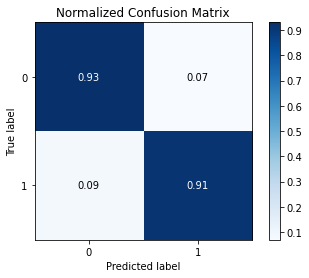

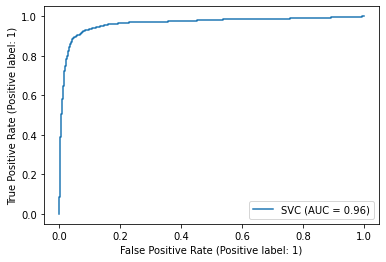

In [11]:
# predict the labels on validation dataset
predictions = clf.predict(X_test_tf)

# compute the performance measures
score = metrics.accuracy_score(y_test, predictions)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_test, predictions, target_names=['no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True)
plt.show()
svc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_test_tf, y_test)

In [12]:
import re
import string
df_val = pd.read_csv('data/revised/test_scarcity_4k.csv')
df_val=df_val.sample(frac=1)

In [13]:
df_val.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df_val=df_val.sample(frac=1)

In [14]:
import string 

df_val['ad'] = df_val['ad'].str.strip().str.lower() 

# Expand contractions 
df_val['ad'] = df_val['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df_val['ad'] =  df_val['ad'].str.translate(str.maketrans('','',string.punctuation))

df_val

,Unnamed: 0,ad,scarcity
2388,2908,every time i hit the road and meet with kansan...,1
1059,4747,it is time to end the nra join us,1
2753,12480,meet and connect with young changemakers in th...,0
4165,12737,james and millions of others voted for trump b...,0
980,1427,official fec deadline midnight on june in a b...,1
...,...,...,...
3855,5999,tiptuesday how to give back during covid,0
2201,225,it is time for you to get ahead get ready to v...,1
1036,3749,with a decision the conservative justices on ...,1
3913,1111,your donation can go far when helps provide at...,0


accuracy:   0.931
              precision    recall  f1-score   support

 no-scarcity       0.93      0.93      0.93      2490
    scarcity       0.93      0.93      0.93      2490

    accuracy                           0.93      4980
   macro avg       0.93      0.93      0.93      4980
weighted avg       0.93      0.93      0.93      4980

confusion matrix:
[[2327  163]
 [ 181 2309]]



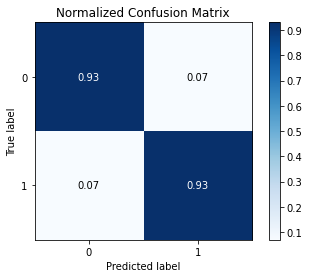

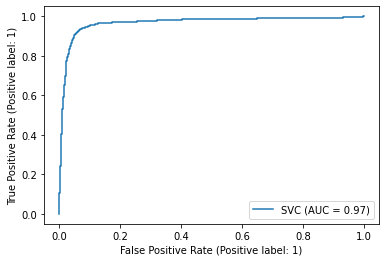

In [15]:
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['scarcity']

y_pred = clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val)

In [22]:
df_val = pd.read_csv('data/hell.csv')

df_val=df_val.sample(frac=1)
df_val.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
df_val['ad'] = df_val['ad'].str.strip().str.lower() 

# Expand contractions 
df_val['ad'] = df_val['ad'].apply(lambda x:expand_contractions(x))

# Remove ponctuation 
df_val['ad'] =  df_val['ad'].str.translate(str.maketrans('','',string.punctuation))

df_val.drop_duplicates(subset ="ad",
                     keep = "first", inplace = True)
X_val = tf_vectorizer.transform(df_val['ad'])
y_val = df_val['scarcity']

accuracy:   0.808
              precision    recall  f1-score   support

 no-scarcity       0.79      0.79      0.79        58
    scarcity       0.82      0.82      0.82        67

    accuracy                           0.81       125
   macro avg       0.81      0.81      0.81       125
weighted avg       0.81      0.81      0.81       125

confusion matrix:
[[46 12]
 [12 55]]



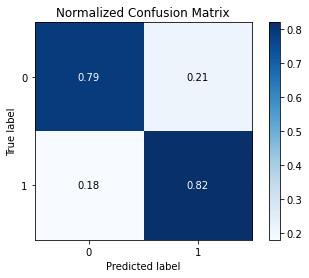

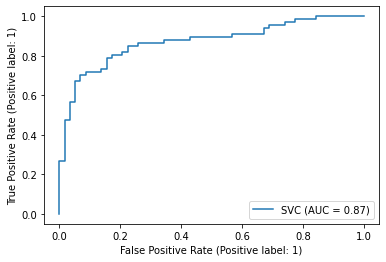

In [23]:
y_pred = clf.predict(X_val)

score = metrics.accuracy_score(y_val, y_pred)
print("accuracy:   %0.3f" % score)

print(metrics.classification_report(y_val, y_pred, target_names=[ 'no-scarcity', 'scarcity']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_val, y_pred))
print()

skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
plt.show()
disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val)

In [18]:
df_val['predictions']=y_pred
df_val.to_csv("verifications_svm.csv")

In [ ]:
from sklearn.pipeline import make_pipeline
clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
my_pipeline = make_pipeline(CountVectorizer(),clf)
cv_scores = cross_validate(my_pipeline,df['ad'],df['scarcity'], 
                            cv=10,
                            scoring=['accuracy', 'precision','recall','f1_micro'])



# Create a dataframe with the models performance metrics scores
model_scores = pd.DataFrame({'Support Vector':[ cv_scores['test_accuracy'].mean(),
                                                                 cv_scores['test_precision'].mean(),
                                                                 cv_scores['test_recall'].mean(),
                                                                 cv_scores['test_f1_micro'].mean(), 
                                                                 ]
                                   },
                                  index=['accuracy', 'precision','recall','f1_micro'])

model_scores